<a href="https://colab.research.google.com/github/vanoha/Machine-Learning/blob/main/Naive_Bayes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets

In [ ]:
dataset = datasets.load_iris()

print(dataset.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

In [ ]:
ext_target = dataset.target[:, None]
# ext_target = np.expand_dims(dataset.target, axis=-1)
df = pd.DataFrame(
    np.concatenate((dataset.data, ext_target, dataset.target_names[ext_target]), axis=1),
    columns=dataset.feature_names + ['target label', 'target name'],
)
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target label,target name
0,5.1,3.5,1.4,0.2,0,setosa
1,4.9,3.0,1.4,0.2,0,setosa
2,4.7,3.2,1.3,0.2,0,setosa
3,4.6,3.1,1.5,0.2,0,setosa
4,5.0,3.6,1.4,0.2,0,setosa


In [ ]:
feature = dataset.data
target = dataset.target

feature.shape, target.shape

((150, 4), (150,))

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

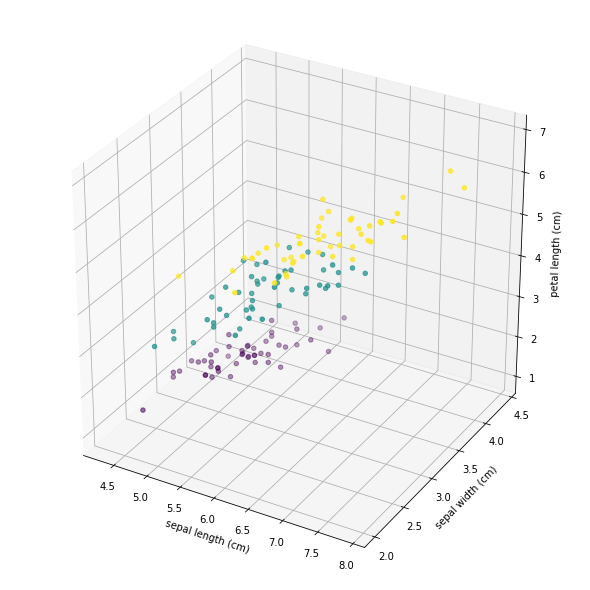

In [ ]:
fig = plt.figure(figsize=(8, 8))

ax = Axes3D(fig)

ax.scatter(feature[:, 0], feature[:, 1], feature[:, 2], c=target, marker='o')
ax.set_xlabel(dataset.feature_names[0])
ax.set_ylabel(dataset.feature_names[1])
ax.set_zlabel(dataset.feature_names[2])

plt.show()

In [ ]:
import plotly.express as px

fig = plt.figure(figsize=(8, 8))
fig = px.scatter_3d(df, x='sepal length (cm)', y='sepal width (cm)', z='petal width (cm)',
                    color='target name')
fig.show()

<Figure size 576x576 with 0 Axes>

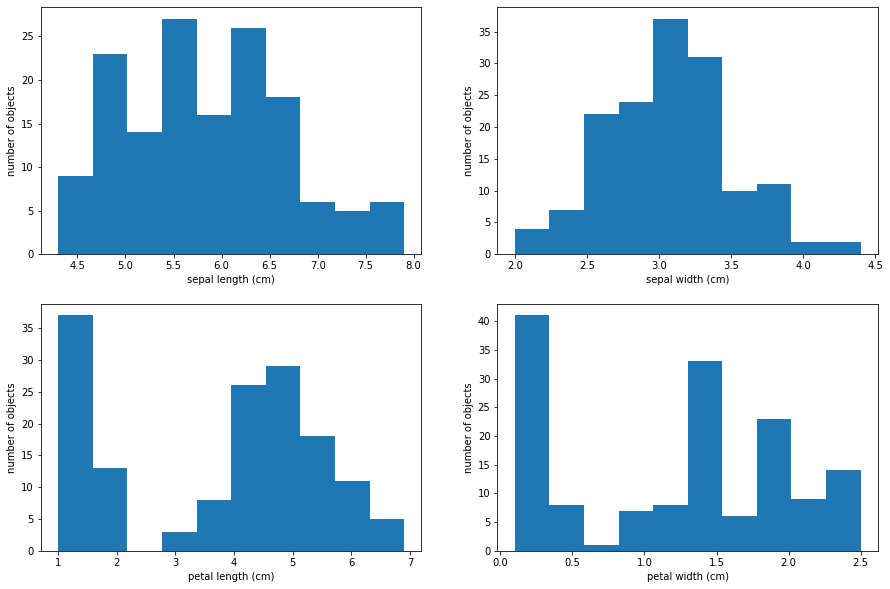

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

for i, axis in enumerate(axes.flat):
    axis.hist(feature[:, i])
    axis.set_xlabel(dataset.feature_names[i])
    axis.set_ylabel('number of objects')

In [ ]:
class GaussianDistribution:
    def __init__(self, feature):
        '''
        Args:
            feature: column of design matrix, represents all available values
                of feature to model.
                axis=0 stays for samples.
        '''
        self.mean = feature.mean(axis=0)
        self.std = feature.std(axis=0)

    def logpdf(self, value):
        '''Logarithm of probability density at value'''
        return  - 0.5 * np.log(2 * np.pi * self.std ** 2) - (value - self.mean) ** 2 / (2 * self.std ** 2)
    
    def pdf(self, value):
        return  np.exp(self.logpdf(value))

In [ ]:
import scipy
_test = scipy.stats.norm(loc=feature[:, :2].mean(axis=0), scale=feature[:, :2].std(axis=0))
assert np.allclose(
    GaussianDistribution(feature[:, :2]).logpdf(feature[:5, :2]),
    _test.logpdf(feature[:5, :2])
)
print('Seems fine!')

Seems fine!


In [ ]:
from scipy.special import logsumexp


class NaiveBayes():
  
  def fit(self, data, labels, distributions=None):

    # unique labels from dataset (in our case we have 4 labels)
    self.unique_labels = np.unique(labels)

    # if distribution of features is not defined, let it be Gaussian
    if distributions is None:
      distributions = [GaussianDistribution] * data.shape[1]
    else:
      # check whether distributions are passed for all features
      assert len(distributions) == data.shape[1]

    # Here we find distribution parameters for every features in every unique label (class)
    # so P(x^i|y=C_k) will be estimated only using information from i-th feature of C_k class values
    self.label_likelihood = {}
    for label in self.unique_labels:
      distr_for_column = []
      for column_i in range(data.shape[1]):
        # `column_index` feature values for objects from `label` class
        feature_column = data[labels == label, column_i]
        distr = distributions[column_i](feature_column)
        distr_for_column.append(distr)
      self.label_likelihood[label] = distr_for_column

    # Prior label distributions (unconditional probability of each class)
    self.label_prior = {
        label: sum((labels == label).astype(float)) / len(labels) for label in self.unique_labels
    }

  def predict_log_proba(self, batch):

    # Here we compute sum(log(P(x^i|y=C_k))) + sum(log(P(y^i)))
    class_log_probas = np.zeros((batch.shape[0], len(self.unique_labels)), dtype=float)
    for label_idx, label in enumerate(self.unique_labels):
      for idx in range(batch.shape[1]):
        class_log_probas[:, label_idx] += self.label_likelihood[label][idx].logpdf(batch[:, idx])
      
      class_log_probas[:, label_idx] += np.log(self.label_prior[label])

    # Here we compute -sum(P(x^i))
    for idx in range(batch.shape[1]):
      class_log_probas -= logsumexp(class_log_probas, axis=1)[:, None]

    return class_log_probas

  def predict_proba(self, X):
    return np.exp(self.predict_log_proba(X))

  def predict(self, X):
    log_probas = self.predict_log_proba(X)
    # we need to cast labels to their original form (they may start from number other than 0)
    # argmax returns indecies of maximum value along the axis
    return np.array([self.unique_labels[idx] for idx in log_probas.argmax(axis=1)])

In [ ]:
nb = NaiveBayes()
nb.fit(feature, target)
print('log probas:\n{}'.format(nb.predict_log_proba(feature[:2])))
print('predicted labels:\n{}'.format(nb.predict(feature[:2])))
print('\nIt`s alive! More tests coming.')

log probas:
[[  0.         -41.14063634 -57.90531295]
 [  0.         -38.72865982 -56.71097942]]
predicted labels:
[0 0]

It`s alive! More tests coming.
